In [1]:
import mido
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import math
%matplotlib inline

import sys
sys.path.insert(0, '../../scripts')

import stft_zoom, display, detect_musical_regions
from util import *
import mappings
import pickle
import PIL
import IPython.display
from classes import SingleResSpectrogram, MultiResSpectrogram
from aug_density_map import *
from mappings import *

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [100]:
def get_refine_map(midi_file, kernel, timestamp, num_time_frames, n_fft=512, hop_size=512):
    midi = mido.MidiFile(midi_file)
    proll = midi_to_piano_roll_new(midi, timestamp)
    proll_den = calc_map_aug2(sound_event_to_tfp(proll, num_time_frames, n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
    return np.array(proll_den > 0, dtype=int)

def get_pct_to_refine(midi_file, kernel, timestamp, n_fft=512, hop_size=512):
    num_time_frames = int(np.ceil(44100 * 30 / hop_size))
    refine_map = get_refine_map(midi_file, kernel, timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
    return 100*(np.sum(refine_map)/refine_map.size)

# fazer: overlap dos detectados com kernel grande e todos kernel pequeno: N
#        overlap dos detectados com kernel pequeno e detectados kernel grande: n
#        o numero que queremos é n/N

# no caso real: N continua o mesmo, overlap dos detectado com kernel pequeno e refinados kernel grande = n

def in_range_list(range, range_list):
    for r in range_list:
        if range[0][0] >= r[0][0] and range[0][1] <= r[0][1]:
            if range[1][0] >= r[1][0] and range[1][1] <= r[1][1]:
                return True
    return False

def all_overlapping_ranges(range_list_1, range_list_2):
    # returns ranges in list_1 that are contained inside the regions defined by range_list_2
    overlapping_ranges = []
    for range in range_list_1:
        if in_range_list(range, range_list_2):
            overlapping_ranges.append(range)
    return overlapping_ranges

def get_pct_to_refine_multilevel(midi_file, kernel_list, timestamp, n_fft=512, hop_size=512, y=None):
# 1. pegar kernel primeiro nivel, ver no ground truth as regioes relevantes, guardar os ranges.
# 2. pegar kernel segundo, ver no ground truth as regioes relevantes, guardar os ranges.
# 3. ver overlap entre passo 2 e 1 = n
# 4. pegar kernel segundo, pegar ranges de todas as subregioes definidas por ele
# 5. ver overlap entre passo 4 e 1 = N
# 6. calcular pct, guardar regiões do passo 3 como as novas subregioes refinadas.
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    x_axis, y_axis = stft_zoom.get_axes_values(44100, 0, [0.0, 30.0], spec.shape) 
    num_time_frames = int(np.ceil(44100 * 30 / hop_size))
    first_level = get_refine_map(midi_file, kernel_list[0], timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
    pct_list = [100*(np.sum(first_level)/first_level.size)]
    indices_first_level = np.where(first_level.flatten() > 0)[0]
    range_list_first = detect_musical_regions.musical_regions_to_ranges(indices_first_level, first_level.shape, x_axis, y_axis, kernel_list[0], n_fft=n_fft, hop_size=hop_size)
    for kernel in kernel_list[1:]:
        second_level = get_refine_map(midi_file, kernel, timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
        indices_second_level = np.where(second_level.flatten() > 0)[0]
        all_subregions_second_level = np.where(second_level.flatten() > -1)[0]
        all_ranges_second_level = detect_musical_regions.musical_regions_to_ranges(all_subregions_second_level, second_level.shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)
        range_list_second = detect_musical_regions.musical_regions_to_ranges(indices_second_level, second_level.shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)
        n = len(all_overlapping_ranges(range_list_second, range_list_first))
        N = len(all_overlapping_ranges(all_ranges_second_level, range_list_first))
        pct_list.append((n/N) * 100)
        range_list_first = range_list_second
    return pct_list

def all_overlapping_ranges_idx(range_list_1, range_list_2):
    # returns ranges in list_1 that are contained inside the regions defined by range_list_2
    overlapping_ranges = []
    i = 0
    for range in range_list_1:
        if in_range_list(range, range_list_2):
            overlapping_ranges.append(i)
        i += 1
    return overlapping_ranges

def get_overlapping_regions(midi_file, kernel_list, timestamp, n_fft=512, hop_size=512, y=None):
# 1. pegar kernel primeiro nivel, ver no ground truth as regioes relevantes, guardar os ranges.
# 2. pegar kernel segundo, ver no ground truth as regioes relevantes, guardar os ranges.
# 3. ver overlap entre passo 2 e 1 = n
# 4. pegar kernel segundo, pegar ranges de todas as subregioes definidas por ele
# 5. ver overlap entre passo 4 e 1 = N
# 6. calcular pct, guardar regiões do passo 3 como as novas subregioes refinadas.
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    x_axis, y_axis = stft_zoom.get_axes_values(44100, 0, [0.0, 30.0], spec.shape) 
    num_time_frames = int(np.ceil(44100 * 30 / hop_size))
    first_level = get_refine_map(midi_file, kernel_list[0], timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
    pct_list = [100*(np.sum(first_level)/first_level.size)]
    indices_first_level = np.where(first_level.flatten() > 0)[0]
    range_list_first = detect_musical_regions.musical_regions_to_ranges(indices_first_level, first_level.shape, x_axis, y_axis, kernel_list[0], n_fft=n_fft, hop_size=hop_size)
    for kernel in kernel_list[1:]:
        second_level = get_refine_map(midi_file, kernel, timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
        indices_second_level = np.where(second_level.flatten() > 0)[0]
        all_subregions_second_level = np.where(second_level.flatten() > -1)[0]
        all_ranges_second_level = detect_musical_regions.musical_regions_to_ranges(all_subregions_second_level, second_level.shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)
        range_list_second = detect_musical_regions.musical_regions_to_ranges(indices_second_level, second_level.shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)
        n = all_overlapping_ranges_idx(range_list_second, range_list_first)
        n_idx = [np.unravel_index(x, second_level.shape) for x in n]
        N = all_overlapping_ranges_idx(all_ranges_second_level, range_list_first)
        N_idx = [np.unravel_index(x, second_level.shape) for x in N]
        range_list_first = range_list_second
    return n_idx, N_idx

In [11]:
file_name = '../../data/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.wav'
midi_file = '../../data/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi'
y, sr = librosa.load(file_name, sr=44100)
timestamp = int((len(y) / sr) // 2)
y = y[sr*timestamp:sr*(timestamp+30)]
time_span = [0,len(y)/sr]

n_fft = 512

hop_size = 512
spec = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
spec_amp = np.abs(spec)
spec_db = librosa.amplitude_to_db(spec_amp, ref=np.min)
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape)
num_time_frames = int(np.ceil(44100 * 30 / hop_size))

In [132]:
get_pct_to_refine(midi_file, [200,200], timestamp, spec.shape[1])

15.789473684210526

In [137]:
get_pct_to_refine_multilevel(midi_file, [[1600,1600], [800,800], [400,400],[200,200]], timestamp, spec.shape[1], y=y)

[36.80555555555556, 71.99175742741696, 73.67766361524994, 74.26826969073345]

In [57]:
kernel = [800,800]
midi = mido.MidiFile(midi_file)
proll = midi_to_piano_roll_new(midi, timestamp)
tfp = sound_event_to_tfp(proll, num_time_frames, n_fft=n_fft)
proll_den = calc_map_aug2(sound_event_to_tfp(proll, num_time_frames, n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


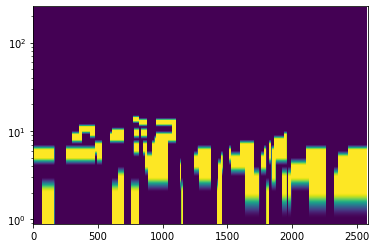

In [58]:
plt.yscale('log')
plt.imshow(np.array(tfp > 0, dtype=int), origin='lower', aspect='auto')

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


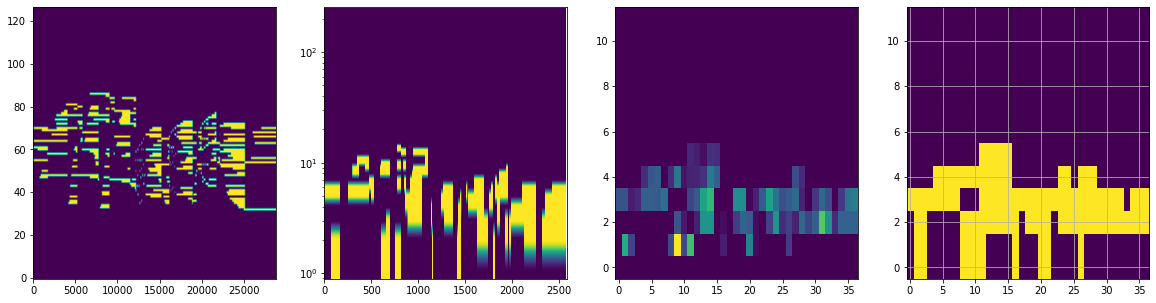

In [59]:
plt.figure(figsize=[20,5])

plt.subplot(1,4,1)
plt.imshow(np.array(proll > 0, dtype=int), origin='lower', aspect='auto')

plt.subplot(1,4,2)
plt.yscale('log')
plt.imshow(np.array(tfp > 0, dtype=int), origin='lower', aspect='auto')

plt.subplot(1,4,3)
plt.imshow(proll_den, origin='lower', aspect='auto')

plt.subplot(1,4,4)
plt.imshow(np.array(proll_den > 0, dtype=int), origin='lower', aspect='auto')
plt.grid()


Text(0.5, 1.0, 'Piano roll')

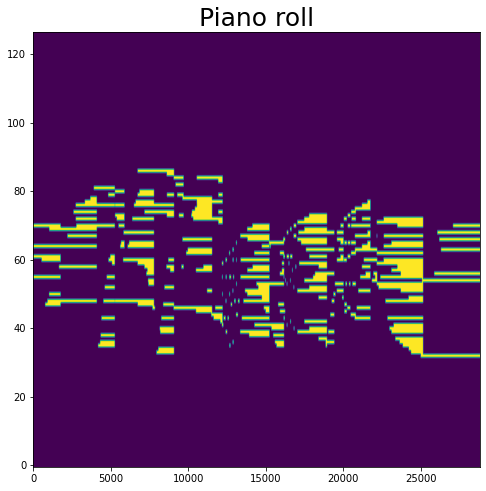

In [88]:
plt.figure(figsize=[8,8])
plt.imshow(np.array(proll > 0, dtype=int), origin='lower', aspect='auto')
plt.title('Piano roll',fontsize=25)

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


[]

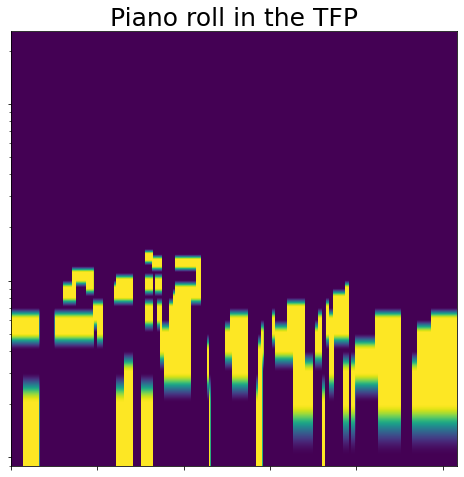

In [85]:
plt.figure(figsize=[8,8])
plt.yscale('log')
plt.imshow(np.array(tfp > 0, dtype=int), origin='lower', aspect='auto')
plt.title('Piano roll in the TFP', fontsize=25)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

Text(0.5, 1.0, 'Interesting subregions - reference value')

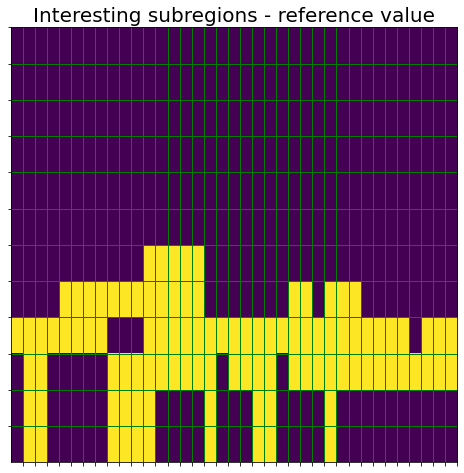

In [87]:
plt.figure(figsize=[8,8])
plt.imshow(np.array(proll_den > 0, dtype=int), origin='lower', aspect='auto')
plt.xticks(np.array(list(range(proll_den.shape[1])))+0.5)
plt.yticks(np.array(list(range(proll_den.shape[0])))+0.5)
plt.grid(color='g', linestyle='-', linewidth=1)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.title('Interesting subregions - reference value', fontsize=20)

Text(0.5, 1.0, 'Interesting subregions - Level 3')

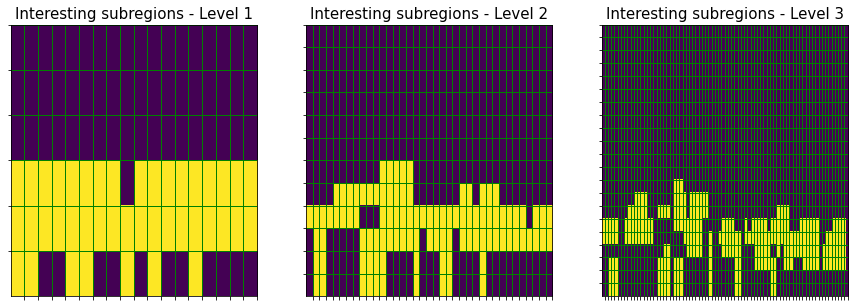

In [140]:
proll_den = calc_map_aug2(sound_event_to_tfp(proll, num_time_frames, n_fft=n_fft), [1600,1600], type='avg', n_fft=n_fft, hop_size=hop_size)

plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
plt.imshow(np.array(proll_den > 0, dtype=int), origin='lower', aspect='auto')
plt.xticks(np.array(list(range(proll_den.shape[1])))+0.5)
plt.yticks(np.array(list(range(proll_den.shape[0])))+0.5)
plt.grid(color='g', linestyle='-', linewidth=1)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.title('Interesting subregions - Level 1', fontsize=15)

proll_den = calc_map_aug2(sound_event_to_tfp(proll, num_time_frames, n_fft=n_fft), [800,800], type='avg', n_fft=n_fft, hop_size=hop_size)

plt.subplot(1,3,2)
plt.imshow(np.array(proll_den > 0, dtype=int), origin='lower', aspect='auto')
plt.xticks(np.array(list(range(proll_den.shape[1])))+0.5)
plt.yticks(np.array(list(range(proll_den.shape[0])))+0.5)
plt.grid(color='g', linestyle='-', linewidth=1)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.title('Interesting subregions - Level 2', fontsize=15)

proll_den = calc_map_aug2(sound_event_to_tfp(proll, num_time_frames, n_fft=n_fft), [400,400], type='avg', n_fft=n_fft, hop_size=hop_size)

plt.subplot(1,3,3)
plt.imshow(np.array(proll_den > 0, dtype=int), origin='lower', aspect='auto')
plt.xticks(np.array(list(range(proll_den.shape[1])))+0.5)
plt.yticks(np.array(list(range(proll_den.shape[0])))+0.5)
plt.grid(color='g', linestyle='-', linewidth=1)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.title('Interesting subregions - Level 3', fontsize=15)

In [130]:
def calc_tfp_pct(ranges):
    tot_tfp_area = 22050 * 30.0
    ranges_area = 0
    for r in ranges:
        ranges_area += (r[0][1] - r[0][0]) * (r[1][1] - r[1][0])
    return ranges_area/tot_tfp_area

In [136]:
def get_pct_to_refine_multilevel(midi_file, kernel_list, timestamp, n_fft=512, hop_size=512, y=None):
# 1. pegar kernel primeiro nivel, ver no ground truth as regioes relevantes, guardar os ranges.
# 2. pegar kernel segundo, ver no ground truth as regioes relevantes, guardar os ranges.
# 3. ver overlap entre passo 2 e 1 = n
# 4. pegar kernel segundo, pegar ranges de todas as subregioes definidas por ele
# 5. ver overlap entre passo 4 e 1 = N
# 6. calcular pct, guardar regiões do passo 3 como as novas subregioes refinadas.
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    x_axis, y_axis = stft_zoom.get_axes_values(44100, 0, [0.0, 30.0], spec.shape) 
    num_time_frames = int(np.ceil(44100 * 30 / hop_size))
    first_level = get_refine_map(midi_file, kernel_list[0], timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
    pct_list = [100*(np.sum(first_level)/first_level.size)]
    indices_first_level = np.where(first_level.flatten() > 0)[0]
    range_list_first = detect_musical_regions.musical_regions_to_ranges(indices_first_level, first_level.shape, x_axis, y_axis, kernel_list[0], n_fft=n_fft, hop_size=hop_size)
    for kernel in kernel_list[1:]:
        second_level = get_refine_map(midi_file, kernel, timestamp, num_time_frames, n_fft=n_fft, hop_size=hop_size)
        indices_second_level = np.where(second_level.flatten() > 0)[0]
        range_list_second = detect_musical_regions.musical_regions_to_ranges(indices_second_level, second_level.shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)
        area_second_lvl = calc_tfp_pct(range_list_second)
        area_first_lvl = calc_tfp_pct(range_list_first)
        pct_list.append((area_second_lvl/area_first_lvl) * 100)
        range_list_first = range_list_second
    return pct_list

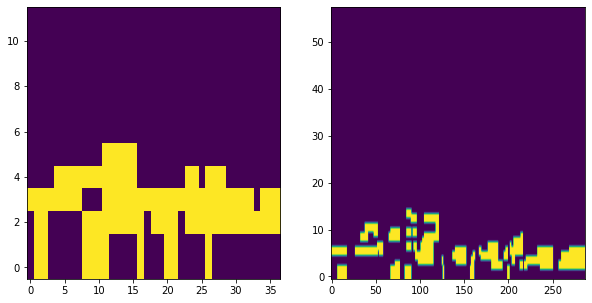

In [13]:
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.imshow(get_refine_map(midi_file, [800,800], timestamp, num_time_frames), origin='lower', aspect='auto')

plt.subplot(1,2,2)
plt.imshow(get_refine_map(midi_file, [100,100], timestamp, num_time_frames), origin='lower', aspect='auto')

In [8]:
second_level = get_refine_map(midi_file, [100,100], timestamp)
indices_second_level = np.where(second_level.flatten() > 0)[0]
all_subregions_second_level = np.where(second_level.flatten() > -1)[0]
# all_ranges_second_level = detect_musical_regions.musical_regions_to_ranges(all_subregions_second_level, second_level.shape, x_axis, y_axis, [100,100], n_fft=n_fft, hop_size=hop_size)

TypeError: get_refine_map() missing 1 required positional argument: 'num_time_frames'

In [7]:
detect_musical_regions.musical_regions_to_ranges([17327], second_level.shape, x_axis, y_axis, [100,100], n_fft=n_fft, hop_size=hop_size)

[([20499.609375, 21791.6015625], [29.904208998548622, 30.0])]

In [18]:
get_pct_to_refine_multilevel(midi_file, [[800,800], [400,400], [200,200], [100,100]], timestamp)

[0.2678132678132678,
 0.7463235294117647,
 0.7811594202898551,
 0.8729372937293729]

In [10]:
# como eu sei que tá certo?

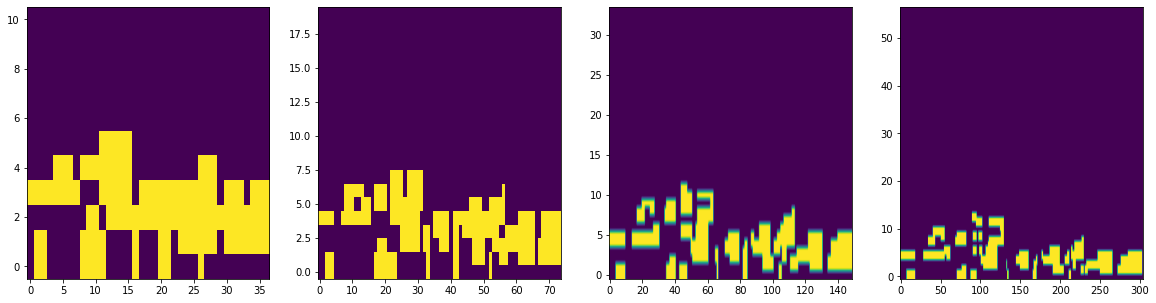

In [11]:
plt.figure(figsize=[20,5])

plt.subplot(1,4,1)
plt.imshow(get_refine_map(midi_file, [800,800], timestamp), origin='lower', aspect='auto')

plt.subplot(1,4,2)
plt.imshow(get_refine_map(midi_file, [400,400], timestamp), origin='lower', aspect='auto')

plt.subplot(1,4,3)
plt.imshow(get_refine_map(midi_file, [200,200], timestamp), origin='lower', aspect='auto')

plt.subplot(1,4,4)
plt.imshow(get_refine_map(midi_file, [100,100], timestamp), origin='lower', aspect='auto')

In [8]:
get_pct_to_refine_multilevel(midi_file, [[800,800], [100,100]], timestamp)

[0.2678132678132678, 0.45948666331152493]

In [31]:
len(x_axis)

10336

In [31]:
first = get_refine_map(midi_file, [1600,1600], timestamp)

In [32]:
second = get_refine_map(midi_file, [800,800], timestamp)

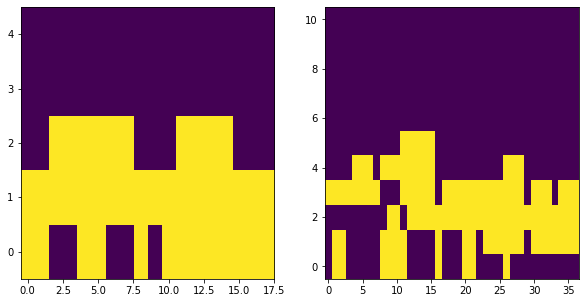

In [33]:
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.imshow(first, aspect='auto', origin='lower')

plt.subplot(1,2,2)
plt.imshow(second, aspect='auto', origin='lower')

In [31]:
kernel = [10,10]

midi = mido.MidiFile(midi_file)
proll = midi_to_piano_roll_new(midi, timestamp)
proll_den = calc_map_aug2(sound_event_to_tfp(proll, spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
res = np.sum(proll_den > 0)/proll_den.size

In [32]:
get_pct_to_refine(midi_file, kernel, timestamp)

0.01524761607639407

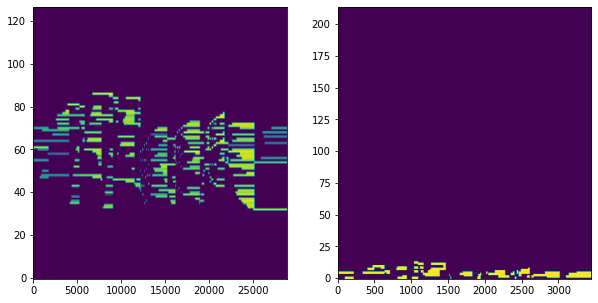

In [33]:
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.imshow(proll, origin='lower', aspect='auto')

plt.subplot(1,2,2)
plt.imshow(np.array(proll_den > 0, dtype=int), origin='lower', aspect='auto')

Fazer uma detecção num espectrograma de janela 512 pra ver o que acontece

In [3]:
model_200 = pickle.load(open('../renyi_shannon_prollharm_200.sav', 'rb'))
model_500 = pickle.load(open('../renyi_shannon_prollharm_500.sav', 'rb'))
model_800 = pickle.load(open('../renyi_shannon_prollharm_800.sav', 'rb'))

In [20]:
def our_solution(y, kernel, n_fft):
    n_fft = 512
    kernel = [1000,1000]

    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=n_fft//4))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)

    indices, original_shape = detect_musical_regions.detect_musical_regions(model_500, spec, kernel=kernel, mode='pct', pct_or_threshold=80, n_fft=n_fft, hop_size=n_fft//4)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=n_fft//4)

    stft_zoom.set_signal_bank(y,kernel, n_fft=n_fft)

    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=5)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)

    multires_spec_vis = multires_spec.generate_visualization()

In [21]:
superspec = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=4096, hop_length=4096//4)), ref=np.max)

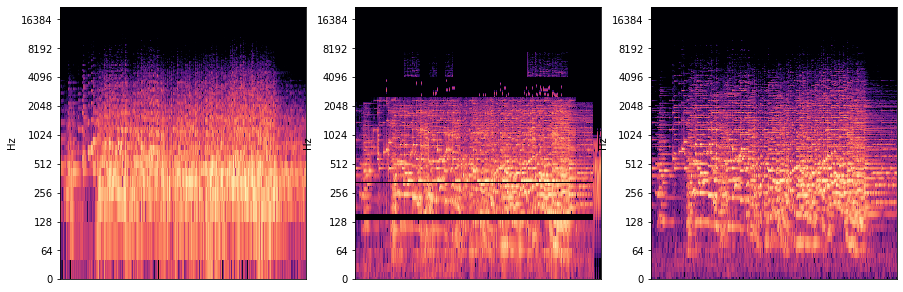

In [22]:
plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', sr=sr)

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_spec_vis, ref=np.max), y_axis='log', sr=sr)

plt.subplot(1,3,3)
librosa.display.specshow(superspec, y_axis='log', sr=sr)

In [24]:
def our_solution(y, res, kernel, model, n_fft, hop_size, sr=44100):
    spec = np.abs(librosa.stft(y, n_fft=n_fft))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)

    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=80, n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel, n_fft=n_fft)

    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)
        
    return multires_spec

In [27]:
n_fft = 512
hop_size = 128
%timeit -n 3 -r 3 our_solution(y, 5, [800,800], model_800, n_fft, hop_size)

1.23 s ± 20.7 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [17]:
def get_pct_to_refine(midi_file, kernel, timestamp, n_fft=512, hop_size=512//4):
    midi = mido.MidiFile(midi_file)
    proll = midi_to_piano_roll_new(midi, timestamp)
    proll_den = calc_map_aug2(sound_event_to_tfp(proll, spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
    return np.sum(proll_den > 0)/proll_den.size

In [18]:
file_name = '../../data/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.wav'
midi_file = '../../data/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi'
y, sr = librosa.load(file_name, sr=44100)
timestamp = int((len(y) / sr) // 2)
y = y[sr*timestamp:sr*(timestamp+30)]

In [30]:
n_fft = 4096
hop_size = n_fft//4
get_pct_to_refine(midi_file, [800,800], timestamp, n_fft=n_fft, hop_size=hop_size)

0.28114035087719297